In [1]:
# import sys
# !{sys.executable} -m pip install datashader matplotlib "napari[all]" pandas seaborn tifffile

In [71]:
import colorcet as cc
import datashader as ds
import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import seaborn as sns

from datashader.mpl_ext import dsshow
from scipy.stats import norm
from skimage import measure, morphology
from tifffile import imread

from simutome.estim import CellMaskSlicer, measure_cell_mask

# Parameter estimation

## Image loading

In [3]:
img_file = "../data/kuett_catena_2021/main_her2_brca_model/img.tiff"
mask_file = "../data/kuett_catena_2021/main_her2_brca_model/mask.tiff"
panel_file = "../data/kuett_catena_2021/main_her2_brca_model/panel.csv"
channel_name_col = "target"
voxel_size_um = (2.0, 1.0, 1.0)
erosion_footprint = morphology.disk(1.0)[None, :, :]  # None

In [4]:
# load image
img = imread(img_file)
assert img.ndim == 4
print(f"Loaded image with shape {img.shape}")

# load mask
mask = imread(mask_file)
assert mask.ndim == 3
assert mask.shape[0] == img.shape[0]
assert mask.shape[1:] == img.shape[2:]
print(f"Loaded mask with shape {mask.shape} containing {np.unique(mask).size - 1} labels")

# erode previously dilated pixels to correct for axis inconsistencies
if erosion_footprint is not None:
    mask *= morphology.binary_erosion(mask != 0, erosion_footprint)
    print(f"Eroded mask, now containing {np.unique(mask).size - 1} labels")

# relabel mask to avoid duplicated cell IDs
mask, num_cells = measure.label(mask, return_num=True)
print(f"Relabeled mask containing {num_cells} cells")

# remove border cells to avoid biases
border_cells = np.unique(
    np.concatenate(
        (
            np.unique(mask[[0, -1], :, :]),
            np.unique(mask[:, [0, -1], :]),
            np.unique(mask[:, :, [0, -1]]),
        )
    )
)
mask[np.isin(mask, border_cells)] = 0
print(f"Removed {len(border_cells) - 1} border cells from mask")

# crop image & mask to speed up computation
ix = np.flatnonzero(np.amax(mask, axis=(0, 1)) != 0)
iy = np.flatnonzero(np.amax(mask, axis=(0, 2)) != 0)
iz = np.flatnonzero(np.amax(mask, axis=(1, 2)) != 0)
img = img[:, :, :, np.amin(ix):np.amax(ix) + 1]
img = img[:, :, np.amin(iy):np.amax(iy) + 1, :]
img = img[np.amin(iz):np.amax(iz) + 1, :, :, :]
mask = mask[:, :, np.amin(ix):np.amax(ix) + 1]
mask = mask[:, np.amin(iy):np.amax(iy) + 1, :]
mask = mask[np.amin(iz):np.amax(iz) + 1, :, :]
print(f"Cropped image and mask to shape {mask.shape}")

# load panel
panel = pd.read_csv(panel_file, usecols=[channel_name_col])
channel_names = panel[channel_name_col].tolist()
assert len(channel_names) == img.shape[1]
print("Channels:")
for i, channel_name in enumerate(channel_names):
    print(f"  {i:2d} {channel_name}")

Loaded image with shape (152, 27, 488, 652)
Loaded mask with shape (152, 488, 652) containing 57916 labels
Eroded mask, now containing 57915 labels
Relabeled mask containing 108596 cells
Removed 9358 border cells from mask
Cropped image and mask to shape (150, 486, 650)
Channels:
   0 Histone H3
   1 Cytokeratin 5
   2 Cytokeratin 19
   3 Cytokeratin 8/18
   4 CD68
   5 Keratin 14
   6 SMA
   7 Vimentin
   8 CD138 (syndecan-1)
   9 CD3 epsilon
  10 phospho-Histone H3
  11 c-erbB-2 (HER2)
  12 CD44
  13 Myeloperoxidase (MPO)
  14 CD45
  15 CD20
  16 CD8a
  17 Collagen I
  18 Ki-67
  19 phospho-S6
  20 VWF + CD31
  21 E/P-Cadherin
  22 Cytokeratin 7
  23 pan-Cytokeratin
  24 cleaved PARP/Caspase 3
  25 DNA1
  26 DNA2


In [5]:
# viewer = napari.Viewer()
# viewer.add_image(
#     img[:, ::-1, :, :],
#     channel_axis=1,
#     colormap="gray", 
#     name=channel_names[::-1],
#     scale=voxel_size_um, 
#     visible=False,
# );
# viewer.add_labels(
#     mask,
#     name="Cell mask",
#     scale=voxel_size_um,
#     visible=False,
# );

## Cell measurement

In [6]:
# cell_data = measure_cell_mask(mask, voxel_size_um=voxel_size_um)
# cell_data["cell_radius_um"] = (0.75 * cell_data["cell_volume_um3"] / np.pi) ** (1 / 3)
# cell_data["proj_cell_radius_x_um"] = (cell_data["proj_cell_area_x_um2"] / np.pi) ** 0.5
# cell_data["proj_cell_radius_y_um"] = (cell_data["proj_cell_area_y_um2"] / np.pi) ** 0.5
# cell_data["proj_cell_radius_z_um"] = (cell_data["proj_cell_area_z_um2"] / np.pi) ** 0.5
# cell_data.to_csv("cell_data.csv", index=False)

cell_data = pd.read_csv("cell_data.csv")

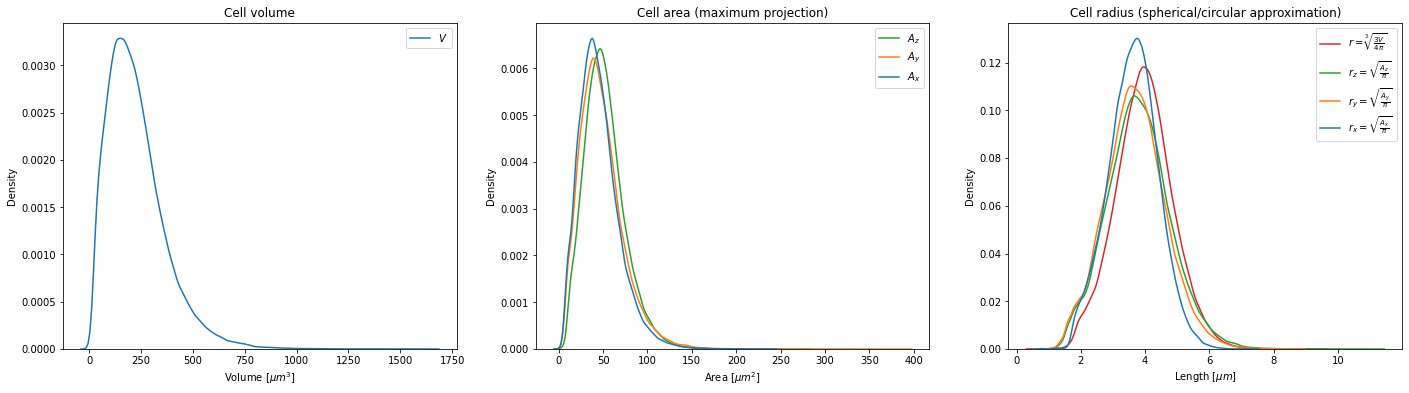

In [7]:
fig, (volume_axis, area_axis, radius_axis) = plt.subplots(ncols=3, figsize=(24, 6))

sns.kdeplot(x="cell_volume_um3", data=cell_data, ax=volume_axis, legend=False)
volume_axis.legend(labels=[r"$V$"])
volume_axis.set_title("Cell volume")
volume_axis.set_xlabel(r"Volume [$\mu m^3$]")
volume_axis.set_ylabel("Density")

area_cols = ["proj_cell_area_x_um2", "proj_cell_area_y_um2", "proj_cell_area_z_um2"]
sns.kdeplot(data=cell_data[area_cols], hue_order=area_cols, ax=area_axis, legend=False)
area_axis.legend(labels=[r"$A_z$", r"$A_y$", r"$A_x$"])
area_axis.set_title("Cell area (maximum projection)")
area_axis.set_xlabel(r"Area [$\mu m^2$]")
area_axis.set_ylabel("Density")

radius_cols = ["cell_radius_um", "proj_cell_radius_x_um", "proj_cell_radius_y_um", "proj_cell_radius_z_um"]
sns.kdeplot(data=cell_data[radius_cols], hue_order=radius_cols, ax=radius_axis, legend=False)
radius_axis.legend(labels=[
    r"$r = \sqrt[3]{\frac{3 V}{4 \pi}}$",
    r"$r_z = \sqrt{\frac{A_z}{\pi}}$",
    r"$r_y = \sqrt{\frac{A_y}{\pi}}$",
    r"$r_x = \sqrt{\frac{A_x}{\pi}}$",
])
radius_axis.set_title("Cell radius (spherical/circular approximation)")
radius_axis.set_xlabel(r"Length [$\mu m$]")
radius_axis.set_ylabel("Density")

plt.show()

## Cell mask sectioning

In [8]:
# sectioning_axes = (2, 1, 0)
# section_thicknesses_um = (2.0, 4.0, 6.0, 8.0, 10.0)
# min_proj_cell_slice_area_um2 = 5.0

# cell_mask_slicer = CellMaskSlicer(mask, voxel_size_um=voxel_size_um)
# cell_slice_infos = cell_mask_slicer.run(sectioning_axes, section_thicknesses_um, progress=True)

# sectioning_cell_slice_data = pd.DataFrame(data=cell_slice_infos)
# sectioning_cell_slice_data = sectioning_cell_slice_data[sectioning_cell_slice_data["proj_cell_slice_area_um2"] >= min_proj_cell_slice_area_um2]
# sectioning_cell_slice_data.insert(1, "sectioning_axis_name", np.array(["z", "y", "x"])[sectioning_cell_slice_data["sectioning_axis"].values])
# sectioning_cell_slice_data["cell_slice_radius_um"] = (0.75 * sectioning_cell_slice_data["cell_slice_volume_um3"] / np.pi) ** (1.0 / 3.0)
# sectioning_cell_slice_data["proj_cell_slice_radius_um"] = (sectioning_cell_slice_data["proj_cell_slice_area_um2"] / np.pi) ** 0.5
# sectioning_cell_slice_data.to_csv("sectioning_cell_slice_data.csv", index=False)

# sectioning_cell_data = sectioning_cell_slice_data.groupby(["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id"]).size().reset_index(name="num_cell_slices")
# sectioning_cell_data.to_csv("sectioning_cell_data.csv", index=False)

sectioning_cell_data = pd.read_csv("sectioning_cell_data.csv")
sectioning_cell_slice_data = pd.read_csv("sectioning_cell_slice_data.csv")

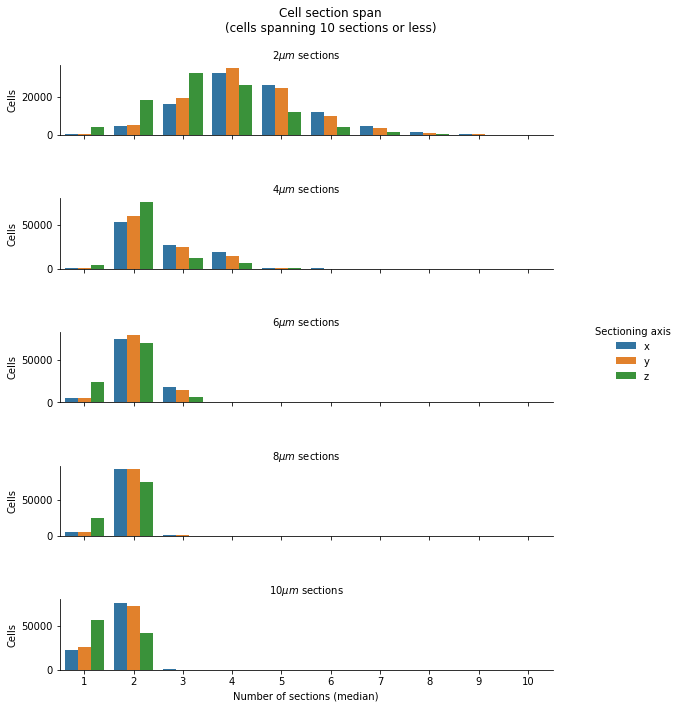

In [9]:
data = sectioning_cell_data.groupby(["sectioning_axis_name", "section_thickness_um", "cell_id"])
data = data["num_cell_slices"].median().round().astype(int).reset_index(name="median_cell_section_span")

g = sns.catplot(
    data=data,
    x="median_cell_section_span",
    hue="sectioning_axis_name",
    hue_order=["x", "y", "z"],
    row="section_thickness_um",
    kind="count",
    height=2,
    aspect=8 / 2,
    sharey=False,
)
g.set(xlabel="Number of sections (median)", ylabel="Cells", xlim=(-0.5, 9.5))
g.legend.set_title("Sectioning axis")
g.set_titles(row_template=r"${row_name:g} \mu m$ sections")
g.fig.suptitle("Cell section span\n(cells spanning 10 sections or less)")
g.fig.subplots_adjust(hspace=0.9, top=0.9)
plt.show()

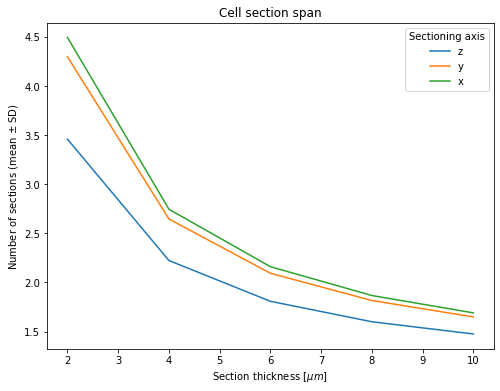

In [10]:
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=sectioning_cell_data,
    x="section_thickness_um",
    y="num_cell_slices",
    hue="sectioning_axis_name",
    hue_order=["z", "y", "x"],
    markers=True,
    ci=None,  # "sd"
)
plt.title("Cell section span")
plt.xlabel(r"Section thickness [$\mu m$]")
plt.ylabel(r"Number of sections (mean $\pm$ SD)")
plt.legend(title="Sectioning axis")
plt.show()

## Parameter estimation

### Cell exclusion

In [11]:
rng = np.random.default_rng(seed=123)

mu_r = cell_data["proj_cell_radius_z_um"].mean()
sigma_r = cell_data["proj_cell_radius_z_um"].std()
x_r = np.linspace(cell_data["proj_cell_radius_z_um"].min(), cell_data["proj_cell_radius_z_um"].max(), 1000)
y_r = norm.pdf(x_r, mu_r, sigma_r)

k = np.amax(voxel_size_um)
t = sectioning_cell_data["section_thickness_um"].unique()
r = rng.normal(loc=mu_r, scale=sigma_r, size=len(cell_data.index))
s_real = np.ceil(2 * r[:, None] / t[None, :])
n1 = np.floor((t[None, :] - ((2 * r[:, None]) % t[None, :])) / k) + 1
n2 = np.ceil(((2 * r[:, None]) % t[None, :]) / k) - 1
s_sampled = (n1 * s_real + (n2 * (s_real + 1))) / (n1 + n2)

p_exclude = 1 / s_sampled

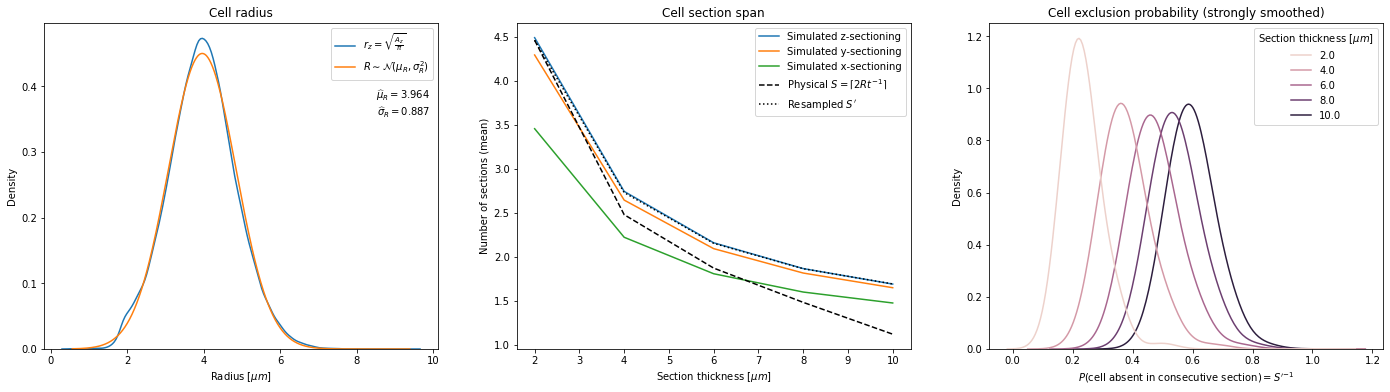

In [12]:
fig, (radius_axis, section_span_axis, exclusion_probability_axis) = plt.subplots(ncols=3, figsize=(24, 6))

sns.kdeplot(
    data=cell_data,
    x="proj_cell_radius_z_um",
    label=r"$r_z = \sqrt{\frac{A_z}{\pi}}$",
    ax=radius_axis,
    legend=False,
)
radius_axis.plot(x_r, y_r, label=r"$R \sim \mathcal{N}(\mu_R, \sigma_R^2)$")
radius_axis.text(
    0.98,
    0.8,
    f"$\\widehat{{\\mu}}_R = {mu_r:.3f}$\n$\\widehat{{\\sigma}}_R = {sigma_r:.3f}$",
    transform = radius_axis.transAxes,
    ha="right",
    va="top",
)
radius_axis.set_title("Cell radius")
radius_axis.set_xlabel(r"Radius [$\mu m$]")
radius_axis.set_ylabel("Density")
radius_axis.legend()

# TODO only show section thicknesses, show markers (why isn't this working?)
sns.lineplot(
    data=sectioning_cell_data,
    x="section_thickness_um",
    y="num_cell_slices",
    hue="sectioning_axis_name",
    hue_order=["x", "y", "z"],
    markers=True,
    ci=None,
    ax=section_span_axis,
    legend=False,
)
sns.lineplot(
    data=pd.DataFrame(data=s_real, columns=t).melt(var_name="section_thickness_um", value_name="real_cell_section_spann"),
    x="section_thickness_um",
    y="real_cell_section_spann",
    markers=True,
    ci=None,
    ax=section_span_axis,
    legend=False,
    color="black",
    ls="--",
)
sns.lineplot(
    data=pd.DataFrame(data=s_sampled, columns=t).melt(var_name="section_thickness_um", value_name="sampled_cell_section_span"),
    x="section_thickness_um",
    y="sampled_cell_section_span",
    markers=True,
    ci=None,
    ax=section_span_axis,
    legend=False,
    color="black",
    ls=":",
)
section_span_axis.set_title("Cell section span")
section_span_axis.set_xlabel(r"Section thickness [$\mu m$]")
section_span_axis.set_ylabel(r"Number of sections (mean)")
section_span_axis.legend(labels=[
    r"Simulated z-sectioning",
    r"Simulated y-sectioning",
    r"Simulated x-sectioning",
    r"Physical $S = \lceil 2 R t^{-1} \rceil$",
    r"Resampled $S'$",
])

p = sns.kdeplot(
    data=pd.DataFrame(data=p_exclude, columns=t).melt(var_name="section_thickness_um", value_name="cell_exclusion_probability"),
    x="cell_exclusion_probability",
    hue="section_thickness_um",
    bw_adjust=8,
    ax=exclusion_probability_axis,
)
p.legend_.set_title(r"Section thickness [$\mu m$]")
exclusion_probability_axis.set_title(f"Cell exclusion probability (strongly smoothed)")
exclusion_probability_axis.set_xlabel(r"$P($cell absent in consecutive section$) = S'^{-1}$")
exclusion_probability_axis.set_ylabel(r"Density")

plt.show()

### Cell slice displacement

In [13]:
# sectioning_cell_slice_displacement_data = sectioning_cell_slice_data.set_index(["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id", "cell_slice_number"]).sort_index()
# sectioning_cell_slice_displacement_data = sectioning_cell_slice_displacement_data[["cell_slice_centroid_x_um", "cell_slice_centroid_y_um", "cell_slice_centroid_z_um", "proj_cell_slice_centroid_x_um", "proj_cell_slice_centroid_y_um"]]
# sectioning_cell_slice_displacement_data = sectioning_cell_slice_displacement_data - sectioning_cell_slice_displacement_data.groupby(["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id"], sort=False).shift()
# sectioning_cell_slice_displacement_data.dropna(inplace=True)
# sectioning_cell_slice_displacement_data.reset_index(inplace=True)
# sectioning_cell_slice_displacement_data.to_csv("sectioning_cell_slice_displacement_data.csv", index=False)

sectioning_cell_slice_displacement_data = pd.read_csv("sectioning_cell_slice_displacement_data.csv")

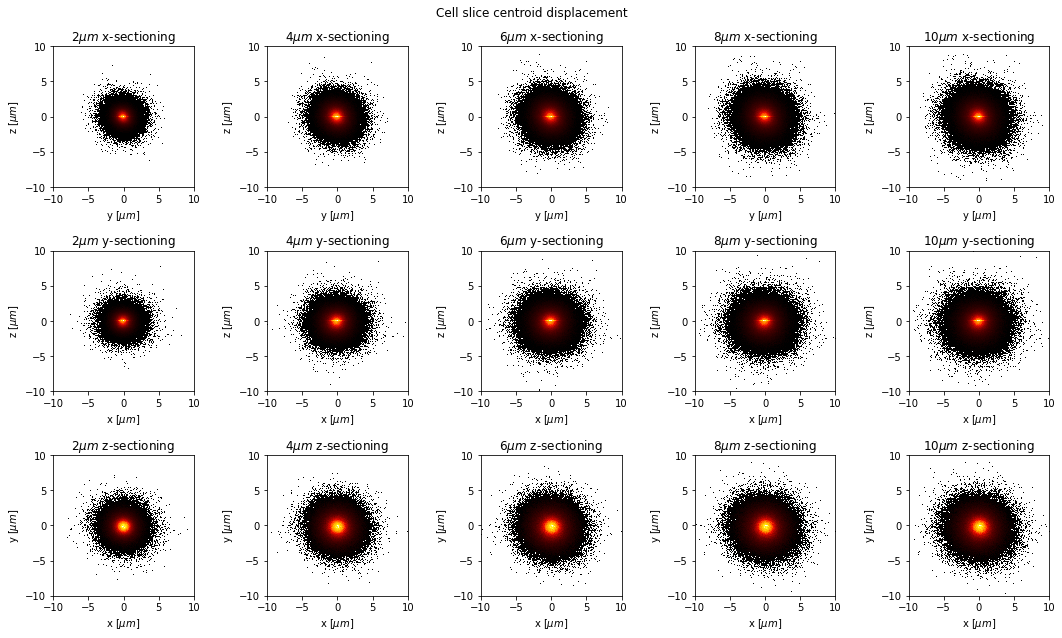

In [91]:
# TODO scale
# TODO why doesn't projection work?
# TODO visualize z as 2D gaussians (use mean variance)
# TODO find thickness-dependent model for SD/variance

sectioning_axis_names = ("x", "y", "z")
fig, axes = plt.subplots(nrows=3, ncols=df["section_thickness_um"].nunique(), figsize=(15, 9))
for (i, row_axes), sectioning_axis_name in zip(enumerate(axes), sectioning_axis_names):
    x, y = tuple(a for a in sectioning_axis_names if a != sectioning_axis_name)
    df = sectioning_cell_slice_displacement_data[sectioning_cell_slice_displacement_data["sectioning_axis_name"] == sectioning_axis_name]
    for (j, ax), (section_thickness_um, g) in zip(enumerate(row_axes), df.groupby("section_thickness_um")):
        dsshow(g, ds.Point(f"cell_slice_centroid_{x}_um", f"cell_slice_centroid_{y}_um"), cmap=cc.fire, ax=ax)
        ax.set_title(f"${section_thickness_um:g} \\mu m$ {sectioning_axis_name}-sectioning")
        ax.set_xlabel(f"{x} [$\\mu m$]")
        ax.set_ylabel(f"{y} [$\\mu m$]")
        ax.set_ylim(-10, 10)
        ax.set_xlim(-10, 10)
plt.suptitle("Cell slice centroid displacement")
plt.tight_layout()
plt.show()

In [82]:
df = sectioning_cell_slice_displacement_data[sectioning_cell_slice_displacement_data["sectioning_axis_name"] == "z"]
df.groupby("section_thickness_um")[["cell_slice_centroid_x_um", "cell_slice_centroid_y_um"]].mean()

,cell_slice_centroid_x_um,cell_slice_centroid_y_um
section_thickness_um,,
2.0,-0.003023,-0.132647
4.0,-0.008981,-0.210557
6.0,-0.013018,-0.245893
8.0,-0.014237,-0.258980
10.0,-0.015415,-0.264913


In [83]:
df = sectioning_cell_slice_displacement_data[sectioning_cell_slice_displacement_data["sectioning_axis_name"] == "z"]
df.groupby("section_thickness_um")[["cell_slice_centroid_x_um", "cell_slice_centroid_y_um"]].cov()

cell_slice_centroid_x_um  \
section_thickness_um                                                      
2.0                  cell_slice_centroid_x_um                  1.064922   
                     cell_slice_centroid_y_um                 -0.037679   
4.0                  cell_slice_centroid_x_um                  1.686784   
                     cell_slice_centroid_y_um                 -0.059240   
6.0                  cell_slice_centroid_x_um                  1.987132   
                     cell_slice_centroid_y_um                 -0.072440   
8.0                  cell_slice_centroid_x_um                  2.100294   
                     cell_slice_centroid_y_um                 -0.078452   
10.0                 cell_slice_centroid_x_um                  2.135266   
                     cell_slice_centroid_y_um                 -0.081272   

                                               cell_slice_centroid_y_um  
section_thickness_um                                                     
2.0                  cell_slice_centroid_x_um                 -0.037679  
                     cell_slice_centroid_y_um                  0.945738  
4.0                  cell_slice_centroid_x_um                 -0.059240  
                     cell_slice_centroid_y_um                  1.487934  
6.0                  cell_slice_centroid_x_um                 -0.072440  
                     cell_slice_centroid_y_um                  1.743214  
8.0                  cell_slice_centroid_x_um                 -0.078452  
                     cell_slice_centroid_y_um                  1.838385  
10.0                 cell_slice_centroid_x_um                 -0.081272  
                     cell_slice_centroid_y_um                  1.867348

### Cell data transformation